In [20]:
from tensorflow.keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate,Reshape,Add,LSTM,Multiply,Embedding,LSTM, GRU,BatchNormalization

from tensorflow.keras.layers import Bidirectional, LeakyReLU
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time


from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import re

import pymorphy2

from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import text_to_word_sequence,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences,TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import collections


### Загрузим данные
размер словаря - 84267 слов,количество предложений - 73477, максимальная длинна текста - 398 символов, максимальное количество слов в предложении - 190


In [43]:
text=np.array(pd.read_csv('data.csv'))
predictions=text[:,2]

### Проведем токенизацию

То есть разобьем исходные предложения на слова

In [2]:
def processText(data):
    tokens=[]
    for line in data:
        newToken=text_to_word_sequence(line[2],filters='!"#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\ufeff',
                                  lower=True,split=' ')
        tokens.append(newToken)
    return tokens

In [5]:
text_tokens=processText(text)
print(text_tokens[0])

['любые', 'разногласия', 'во', 'мнениях', 'скоро', 'улягутся', 'а', 'вы', 'продолжайте', 'делать', 'как', 'делали', 'но', 'постарайтесь', 'не', 'наступать', 'на', 'ноги', 'слишком', 'многим', 'иначе', 'ваши', 'сегодняшние', 'действия', 'сыграют', 'против', 'вас', 'в', 'будущем']


### Заменим слова в предложениях на соответсвующие в словаре индексы

In [5]:
num_words = 20000 #84267
tokenizer = Tokenizer(
    num_words=num_words,
    filters='!"#$%&amp;()*+,-—./:;&lt;=>?@[\\]^_`{|}~\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    char_level=False) 


tokenizer.fit_on_texts(text_tokens) 
sequences = tokenizer.texts_to_sequences(text_tokens)

### Зафиксируем характеристики выборки

In [6]:
max_len=0 # максимальная длина предложения

for seq in sequences:
    l=len(seq)
    if l> max_len:
        max_len=l


vocab_len = len(tokenizer.word_index)
embedding_dim=300 # длина эмбеддинга слова

print('максимальное количество слов в предложении ', max_len)
print('длина словаря ', vocab_len)
print('длина эмбеддинга ',embedding_dim)

максимальное количество слов в предложении  188
длина словаря  84267
длина эмбеддинга  300


### Дополним предожения нулями до одной длины

In [7]:
sequences = pad_sequences(sequences = sequences, maxlen = max_len,padding='post')
print('текст предложения\n',sequences[1][:50])
print('размерность всего массива',sequences.shape)

текст предложения
 [  993     9   459  4145  1640   200     5   440    87     8  1118 12000
     2  1851  8608 14200    38   775     1  2501 13658    14    44 16338
    34     7  1162   452  1178    57     1     7   207    53     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
размерность всего массива (73477, 188)


### Считаем сохраненные веса word2vec

In [38]:
model_w2v= KeyedVectors.load_word2vec_format('weights/araneum_upos_skipgram_300_2_2018.vec.gz')
#w2v = Word2Vec.load("weights/word2vec.model")

In [39]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [40]:
index2word_set = set(model_w2v.index_to_key)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [44]:
w2v_vectors = [text_to_vec(txt) for txt in predictions]

### Создадим матрицу эмбеддингов

In [11]:
embedding_matrix = w2v.wv.vectors

scaler=MinMaxScaler((-1,1))
print('до нормализации\n',embedding_matrix[458][:10])

embedding_matrix=scaler.fit_transform(embedding_matrix)
print('после нормализации\n',embedding_matrix[458][:10])

до нормализации
 [-0.6245368  -1.3930552  -3.2870445  -0.53247976 -1.3066322  -4.748493
 -0.9808279  -0.87501806 -4.233118    3.80411   ]
после нормализации
 [ 0.00100999 -0.02932662 -0.27354166  0.06112456 -0.14094234 -0.27567697
  0.05776033 -0.03154409 -0.17836615  0.26318383]


### Создадим обучающую выборку

 Например для текста "The sky was falling due to apocalypse " будет
 
 "The sky" -> was
 
 "sky was" -> falling
 
 " was falling " -> due 
 
 " falling due" -> to
 
 "due to " -> apocalypse
 


In [12]:
def word2idx(word):
    return w2v.wv.vocab[word].index

def idx2word(idx):
    return w2v.wv.index_to_key[idx]


In [13]:
window_step=5
N=500000
step=1
count=0

x=[]
y=[]


for line in sequences:
    if count>=N:
        break
        
    for j in range(0, len(line) - step-window_step, step):
        temp=[]
        for i in range(window_step):
            temp.append(line[j+i])
       
        x.append(temp)
        y.append(embedding_matrix[line[j+window_step]])
    
x=np.array(x)
y=np.array(y)
    
print('x shape ',x.shape)
print('y shape ',y.shape)

x shape  (13372814, 5)
y shape  (13372814, 300)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.01,shuffle=False) #, random_state = 42)

In [ ]:
del x_train
del y_train
del x_test
del y_test

## Обучим модель

In [16]:
model= Sequential()

model.add(Embedding(input_dim = vocab_len, 
                    output_dim = embedding_dim, 
                    weights=[embedding_matrix],
                    trainable=False
                             ))
model.add(Dense(300,input_shape=(window_step,embedding_dim)))
model.add(LeakyReLU(0.2))

#modelGRU.add(Embedding(num_words, embedding_size))
#modelGRU.add(SpatialDropout1D(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(256,return_sequences=True))
model.add(GRU(512,return_sequences=True))
model.add(BatchNormalization())
        
model.add(LSTM(512,return_sequences=True))
model.add(GRU(1024))
model.add(BatchNormalization())

#modelGRU.add(Bidirectional(LSTM(128)))
#modelGRU.add(LSTM(8,return_sequences=True ))
#model.add(LSTM(128))

model.add(Dense(256))
model.add(LeakyReLU(0.2))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(LeakyReLU(0.2))

model.add(Dense(embedding_dim,activation = 'tanh'))
#model.summary()


In [17]:
optimizer=RMSprop(0.0001)
#optimizer=Adam(0.0001)
model.compile(loss="mse", optimizer=optimizer,metrics=["mae"])
history = model.fit(x, y, batch_size=3000, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
4012/4012 [==============================] - 290s 70ms/step - loss: 0.0146 - mae: 0.0614 - val_loss: 0.0093 - val_mae: 0.0379
Epoch 2/50
4012/4012 [==============================] - 282s 70ms/step - loss: 0.0112 - mae: 0.0455 - val_loss: 0.0093 - val_mae: 0.0378
Epoch 3/50
 168/4012 [>.............................] - ETA: 4:19 - loss: 0.0112 - mae: 0.0449

KeyboardInterrupt: 

In [94]:
modelGRU = Sequential()
#embedding_layer = w2v.wv.get_keras_embedding(train_embeddings=False)
modelGRU.add(Embedding(input_dim = N, 
                              output_dim = embedding_dim, 
                              
                              input_length =s, 
                             ))
#modelGRU.add(Embedding(num_words, embedding_size))
#modelGRU.add(SpatialDropout1D(0.2))
modelGRU.add(Bidirectional(GRU(128, return_sequences=True)))
modelGRU.add(Bidirectional(GRU(256)))
#modelGRU.add(Bidirectional(LSTM(128)))
#modelGRU.add(LSTM(8,return_sequences=True ))
#modelGRU.add(LSTM(128))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(64))
modelGRU.add(LeakyReLU(0.2))

modelGRU.add(Dense(num_words,activation = 'softmax'))
#modelGRU.summary()


NameError: name 'sentStep' is not defined

In [24]:
model.save_weights('modelGRU.h5')

In [15]:
model.load_weights_weights('modelGRU.h5')

In [90]:
emb2indx=Sequential()

emb2indx.add(Dense(256,input_shape=(300,)))
emb2indx.add(LeakyReLU(0.2))

emb2indx.add(Dense(1024))
emb2indx.add(LeakyReLU(0.2))


emb2indx.add(Dense(vocab_len))
emb2indx.add(Activation('softmax'))

emb2indx.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 256)               77056     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              263168    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 84267)             86373675  
_________________________________________________________________
activation_6 (Activation)    (None, 84267)             0         
Total params: 86,713,899
Trainable params: 86,713,899
Non-trainable params: 0
__________________________________________

In [91]:
embedding_matrix_label=np.arange(0,vocab_len)

x_train, _, y_train, _ = train_test_split(embedding_matrix,
                                          embedding_matrix_label,
                                          test_size = 0.01,
                                          shuffle=True) #, random_state = 42)

In [92]:
optimizer=RMSprop(0.01)
optimizer=Adam(0.01)
emb2indx.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["categorical_accuracy"])
history2 = emb2indx.fit(x_train, y_train, batch_size=512, epochs=20, validation_split=0.1, verbose=1)

Epoch 1/20
147/147 [==============================] - 6s 40ms/step - loss: 11.6079 - categorical_accuracy: 0.0000e+00 - val_loss: 11.4582 - val_categorical_accuracy: 0.0000e+00
Epoch 2/20
147/147 [==============================] - 6s 39ms/step - loss: 11.6012 - categorical_accuracy: 0.0000e+00 - val_loss: 13.0873 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
147/147 [==============================] - 6s 39ms/step - loss: 9.8262 - categorical_accuracy: 4.2658e-05 - val_loss: 14.3321 - val_categorical_accuracy: 0.0000e+00
Epoch 4/20
147/147 [==============================] - 6s 39ms/step - loss: 5.6799 - categorical_accuracy: 9.8322e-06 - val_loss: 24.9401 - val_categorical_accuracy: 0.0000e+00
Epoch 5/20
147/147 [==============================] - 6s 39ms/step - loss: 2.4213 - categorical_accuracy: 0.0000e+00 - val_loss: 41.9075 - val_categorical_accuracy: 0.0000e+00
Epoch 6/20
147/147 [==============================] - 6s 39ms/step - loss: 1.7615 - categorical_accuracy: 2.0889e-05 -

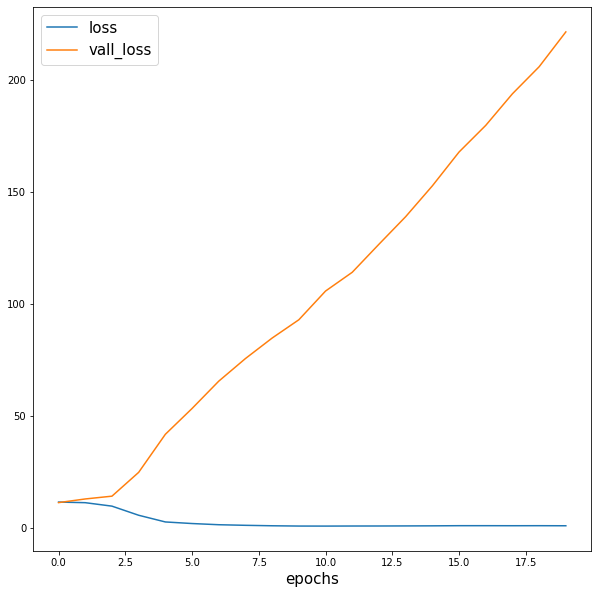

In [93]:
plt.figure(figsize=(10,10))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss','vall_loss'],fontsize=15)
plt.xlabel('epochs',fontsize=15)
plt.show()

In [58]:
words=['Сегодня раки сделали весам хороший']
start_words=np.zeros((1,5,embedding_dim))

sents = tokenizer.texts_to_sequences(words)

for i,sent in enumerate(sents[0]):
    embedding=embedding_matrix[sent].reshape((1,-1))
    start_words[0,i]=scaler.inverse_transform(embedding)

print(start_words[0,:,:20])

[[  1.11940563  -4.47298622   0.65774113  -4.86403894   2.4788835
   -1.92764044   0.06084801  -0.94689554   3.41244149  -2.22464442
    1.65917277   4.02326965  -3.81203103  -0.07682221  -2.97399664
    3.43047047   1.5191133    3.48144889  -3.05387735  -0.19981249]
 [  8.76150036  -3.02618313  -5.61167622  -7.557127     2.9316082
  -11.12590027   3.86868095  -4.16566563  -0.45326442   2.6480093
   -5.87803841  -7.29429388   2.15030169  -1.23684454   0.30451331
    0.68259573  -5.05772114   2.52857542  12.65536308   2.92942691]
 [ -5.33199835   0.51617199  -2.11480713   0.29691482  -1.58108556
    2.70423245  -4.69053364  -4.81633234  -3.94052768   2.50122547
    4.3491683    2.68520594  -3.42910099   2.8538785    6.86081362
    4.45629978   4.4436059    5.10120296  -5.38503122  -6.79748487]
 [  0.10566183   1.39336932  -1.75582969   1.68297565   1.41040981
   -5.65944958   3.47622252  -6.91624498   3.06348443   4.80276775
    4.22399759   0.09041955   1.41429913  -2.21025276  -0.3272

In [41]:
n=20

for i in range(n):
    res=model.predict(start_words)
    
    predWord=reverse_word_map[nextIndex]
    print(predWord)
    for j in range(newWords.shape[1]-1):
        newWords[0][j]=newWords[0][j+1]
    newWords[0][2]=nextIndex
    print(nextIndex)
    

['Сегодня раки сделали весам хороший']
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
людьми
60
